### Sequence-to-sequence layers

At the heart of self-attention are sequence-to-sequence layers, or layers which take as an input a sequence of tensors and provide an output sequence of tensors of the same length. 

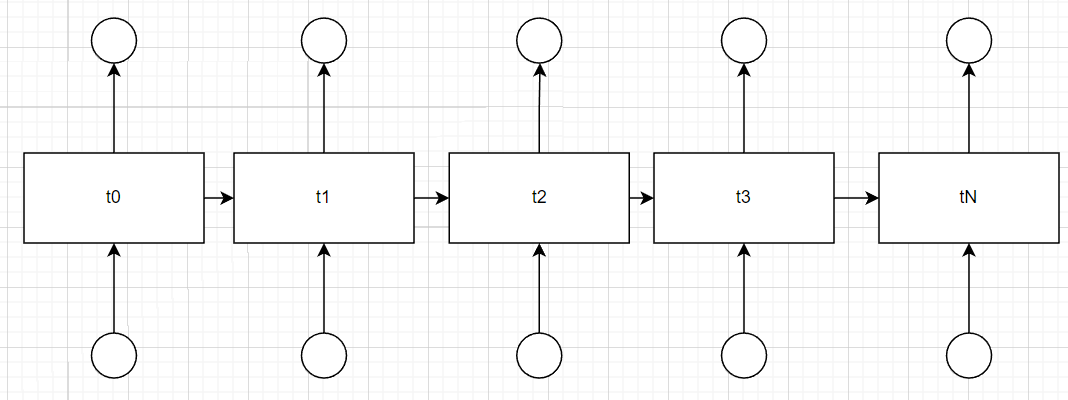

Sequence-to-sequence layers were originally implemented using RNNs ((Cho et al., 2014a) and (Sutskever et al., 2014)), where embedding is used to generate a sequence of vectors which are fed into the RNN network. The encoder portion produces a final latent variable that is then fed into a decoder RNN to produce the output sequence.  

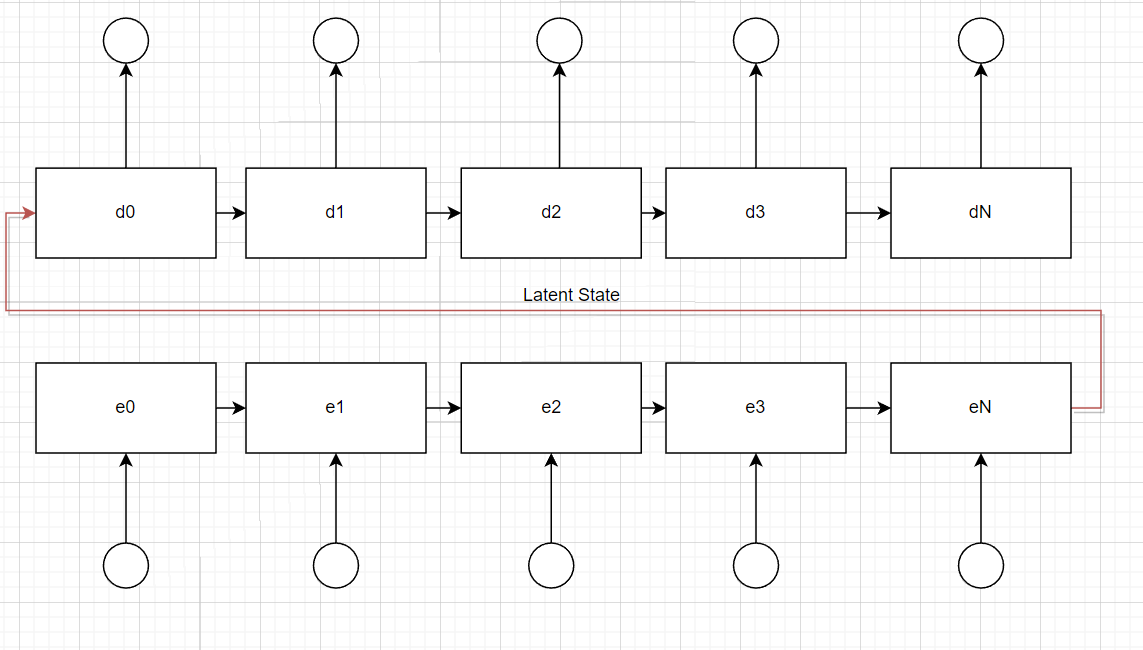

The problem with RNNs is the latent variable being passed around has a limited capacity to properly encode long sequences, and so quality drops off as the input sequence grows in length. This is analogous to a human translator needing to wait for the completion of an entire speech before accurately translating it. Additionally, RNNs are impossible to parallelize due to their recurrent nature. 

CNNs were also introduced as another means of taking an input sequence and producing an output sequence. They can be more easily parallelized and can extend themselves beyond a single latent variable, but relating information between two distant elements of a series requires increasingly more operations (linear for ConvS2S, and logarithmic for ByteNet). 

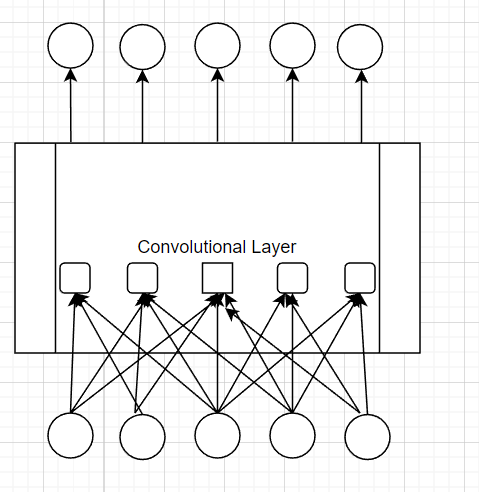

There was therefore a need to provide increased parallelizability in addition to maintaining the ability for information in one element of a sequence to be combined with that of a distant other.  

### Attention

https://arxiv.org/abs/1409.0473 (Neural Machine Translation by Jointly Learning to Align and Translate)

Attention was first introduced in the seminal work "Neural Machine Translation by Jointly Learning to Align and Translate". The main idea is that the encoder becomes a bi-directional RNN while the decoder is a forward-only RNN that sources not only from previous states through a latent variable, but also a context generated by the each of the encoder outputs, weighted by relevance.  

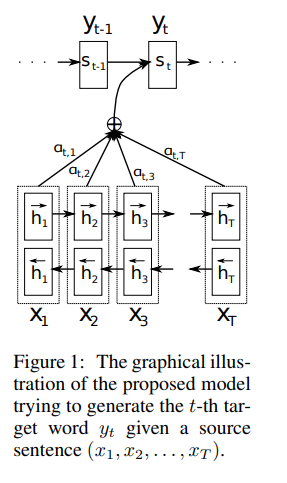

There are two crucial concepts to take away here: the first is that of the context. The context for output element $i$ of the output sequence is defined as: 

$ c_i = \sum_{j=1}^{T_x} a_{ij} h_j  $

So the context being fed to the encoder at a certain step is the weighted sum of all the outputs of the encoder. The weights are softmaxed so they are all positive and sum to 1. 

The second important point to make is that the weights $ a $ are determined by a feedforward neural network co-trained with the rest of the system. The result of this is that different parts of the input sequence are determined to be more important than others, and that the system to determine that is trained by back prop. The paper refers to this as an *alignment model*. 

### Scaled Dot-Production Attention

In the paper _Neural Machine Translation by Jointly Learning to Align and Translate_ the alignment model was a single-layer, feed-forward neural network that was trained alongside the rest of the model. Its purpose is to score how well inputs $ j $ relate to outputs $ i $. However, another alignment model more commonly found in practice today is that of using the dot product itself due to its computational simplicity and lower memory footprint. In the paper _Attention Is All You Need_ the authors propose a scaled dot-product attention mechanism. 

Given a set of embedding vectors $ V 